In [ ]:
import sys

import seaborn
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix

sys.path.append('../../')

from core.datasets import get_ds, open_f
from core.make_answer import make_ans_file 
from core.ensembles import get_bagging_pred, print_bagging_ensemble_statistic, print_models_statistic, get_ensemble_modelbase, get_modeset


c:\Users\Mi\Desktop\ML\.conda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
acc_test_ds = open_f('repaired_data_train', back=2)

In [ ]:
shuffle = np.random.permutation(acc_test_ds['labels'].shape[0])
acc_test_ds_y = acc_test_ds['labels'][shuffle][:10000]
acc_test_ds_x = acc_test_ds['images'][shuffle][:10000] / 255.

In [ ]:
train_ds, val_ds, test_ds = get_ds('repaired_data_train', 'repaired_data_test', one_hot=True, back=2)
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.argmax(val_ds_y, axis=1)

In [ ]:
model_smote = tf.keras.models.load_model(f'../checkpoints/model_s_smote_categorical_accuracy.h5')
model_8 = tf.keras.models.load_model(f'../checkpoints/model_g_8_avg_categorical_accuracy.h5')
model_11 = tf.keras.models.load_model(f'../checkpoints/model_g_11_avg_f1_score.h5')
model_7 = tf.keras.models.load_model(f'../checkpoints/model_g_7_avg_categorical_accuracy.h5')
model_17 = tf.keras.models.load_model(f'../checkpoints/model_g_17_avg_f1_score.h5')

In [ ]:
models = [model_smote, model_8, model_11, model_7, model_17]
names = ['model SMOTE', 'model G8', 'model G11', 'model G7', 'model G17']

modelbase = get_ensemble_modelbase(models=models, names=names, x_val=acc_test_ds_x)

313/313 [==============================] - 15s 47ms/step


In [ ]:
print_models_statistic(modelbase=modelbase, y_val=acc_test_ds_y)

SCORE
model SMOTE: accuracy: 0.9914 f1_score: 0.9912524469970052
model G8: accuracy: 0.9897 f1_score: 0.9901157123789662
model G11: accuracy: 0.9959 f1_score: 0.9958102538569165
model G7: accuracy: 0.9628 f1_score: 0.9607707161019248
model G17: accuracy: 0.9908 f1_score: 0.9908185189167588


In [ ]:
selected_names = ['model SMOTE', 'model G8', 'model G11', 'model G17']
# 'model G7'
modelset = get_modeset(modelbase, selected_names)

было замечено что повышение итогового accuracy на пару тысячных может на кегли может увеличить результат на пару сотых. Так что не стоит делать выводы только по accuracy. 

In [ ]:
y_test_acc_pred = print_bagging_ensemble_statistic(modelset=modelset, y_val=acc_test_ds_y)

SCORE

ensemble accuracy: 0.9973

ensemble f1_score: 0.9972931158061256


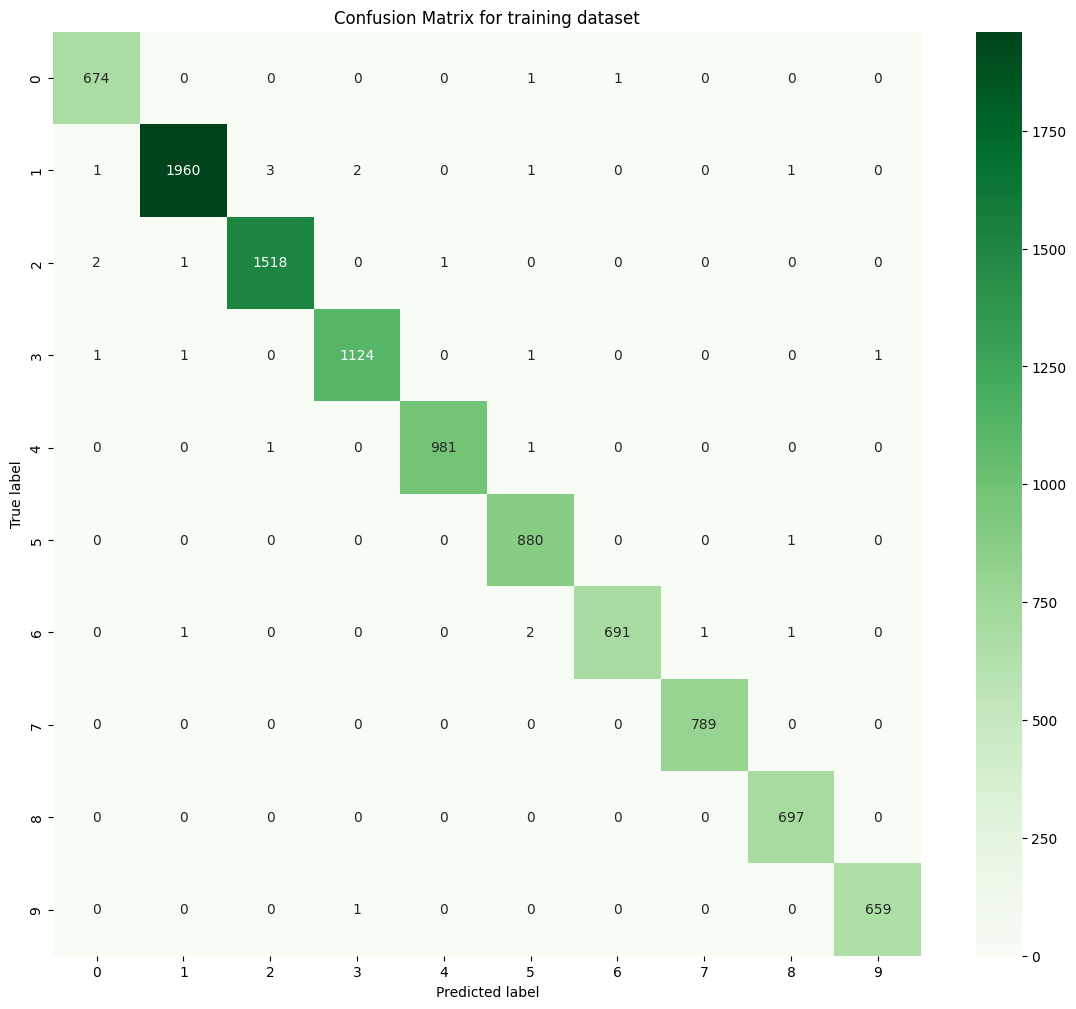

In [ ]:
matrix = confusion_matrix(acc_test_ds_y, y_test_acc_pred)

fig, ax = plt.subplots(figsize=(14, 12))
seaborn.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

делаем тестовый предикт и сохраняем:

In [ ]:
import pandas as pd
wunderwafel_test = get_bagging_pred(modelset=modelset, x_val=test_ds)

In [ ]:
ensemble_model_name = "ensemble_g_2"
ans = pd.DataFrame({'Id': np.arange(wunderwafel_test.shape[0]), 'Category': wunderwafel_test})
ans.to_csv(f"../answers/{ensemble_model_name}.csv", index=False)